# Deep Learning starts here

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
import torchvision
from torchvision import transforms
from torchvision.datasets import VOCSegmentation
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)
import numpy as np
import cv2

def show_tensor_images(image_tensor, num_images=25, size=(3, 150, 300)):

    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [2]:
def add_extra(image):
    image = image.permute(1,2,0)
    ver = np.ones((11,128, 3))
    hor = np.ones((150, 11, 3))
    image = np.vstack([ver,image,ver])
    image = np.hstack([hor,image,hor])
    return image

def convert_to_outline(img):
    image = img.copy()
    image = 0.299 * image[:, :, 0] + 0.587 * image[:, :, 1] + 0.114 * image[:, :, 2]
    image = np.stack([image,image,image], axis=-1)

    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    magnitude = cv2.magnitude(sobel_x, sobel_y)
    normalized_magnitude = cv2.normalize(magnitude, None, 0, 1, cv2.NORM_MINMAX) 
    
    concated = np.hstack([abs(normalized_magnitude -1), img]).astype('float32')
    return concated


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(0.6),
    transforms.RandomVerticalFlip() ,
    transforms.Resize((128,128), antialias=None),
    add_extra,
    convert_to_outline,
    transforms.ToTensor()
    
    
])

dataset = torchvision.datasets.ImageFolder('/kaggle/input/colored-logos/Coloured Logos', transform=transform)

dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
for x,_ in dataloader:
    break

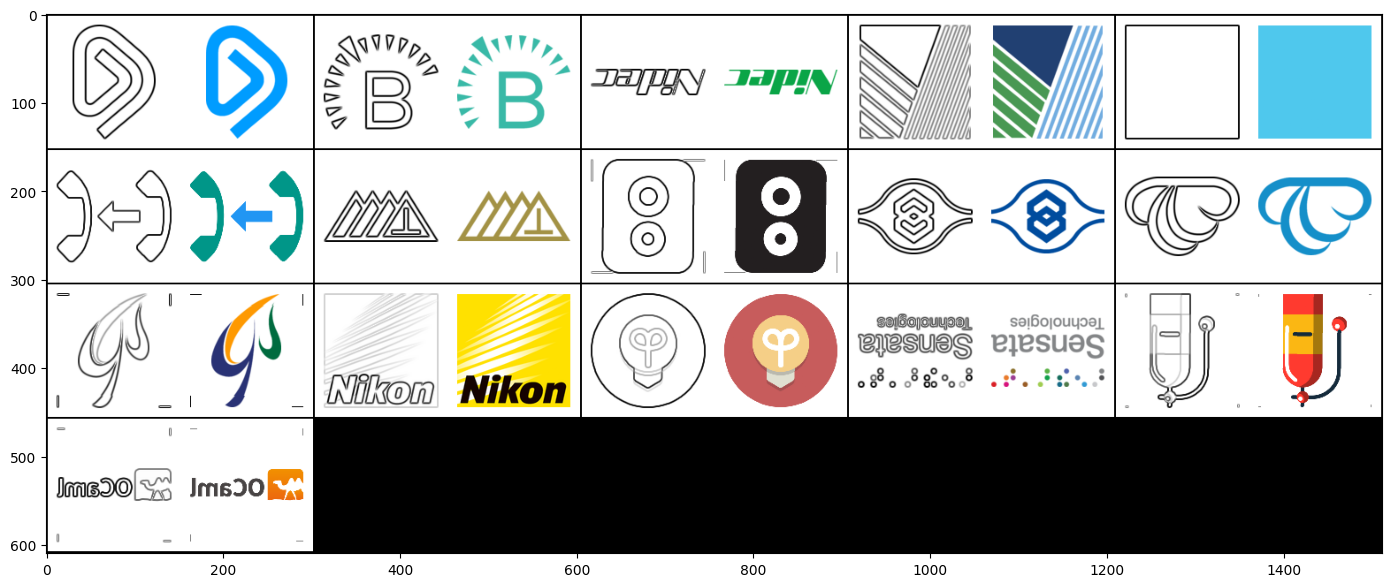

In [3]:
plt.figure(figsize=(18,7))
show_tensor_images(x, num_images=20)

In [4]:
def crop(image, new_shape):

    middle_height = image.shape[2] // 2
    middle_width = image.shape[3] // 2
    starting_height = middle_height - new_shape[2] // 2
    final_height = starting_height + new_shape[2]
    starting_width = middle_width - new_shape[3] // 2
    final_width = starting_width + new_shape[3]
    cropped_image = image[:, :, starting_height:final_height, starting_width:final_width]
    return cropped_image


In [5]:
class ContractingBlock(nn.Module):

    def __init__(self, input_channels, use_dropout=False, use_bn=True):
        super(ContractingBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, input_channels * 2, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(input_channels * 2, input_channels * 2, kernel_size=3, padding=1)
        self.activation = nn.LeakyReLU(0.2)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        if use_bn:
            self.batchnorm = nn.BatchNorm2d(input_channels * 2)
        self.use_bn = use_bn
        if use_dropout:
            self.dropout = nn.Dropout()
        self.use_dropout = use_dropout

    def forward(self, x):

        x = self.conv1(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.conv2(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.maxpool(x)
        return x

In [6]:
img = x[0:1][:,:,:,:150]
cb = ContractingBlock(3)
cb(img).shape


torch.Size([1, 6, 75, 75])

In [7]:
class ExpandingBlock(nn.Module):

    def __init__(self, input_channels, use_dropout=False, use_bn=True):
        super(ExpandingBlock, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv1 = nn.Conv2d(input_channels, input_channels // 2, kernel_size=2)
        self.conv2 = nn.Conv2d(input_channels, input_channels // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(input_channels // 2, input_channels // 2, kernel_size=2, padding=1)
        if use_bn:
            self.batchnorm = nn.BatchNorm2d(input_channels // 2)
        self.use_bn = use_bn
        self.activation = nn.ReLU()
        if use_dropout:
            self.dropout = nn.Dropout()
        self.use_dropout = use_dropout

    def forward(self, x, skip_con_x):

        x = self.upsample(x)
        x = self.conv1(x)
        skip_con_x = crop(skip_con_x, x.shape)
        x = torch.cat([x, skip_con_x], axis=1)
        x = self.conv2(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.conv3(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        return x


In [8]:
class FeatureMapBlock(nn.Module):

    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=1)

    def forward(self, x):

        x = self.conv(x)
        return x

In [9]:
img = x[0:1][:,:,:,:150]
fmb = FeatureMapBlock(3,3)
fmb(img).shape


torch.Size([1, 3, 150, 150])

In [10]:
class UNet(nn.Module):

    def __init__(self, input_channels, output_channels, hidden_channels=32):
        super(UNet, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels, use_dropout=True)
        self.contract2 = ContractingBlock(hidden_channels * 2, use_dropout=True)
        self.contract3 = ContractingBlock(hidden_channels * 4, use_dropout=True)
        self.contract4 = ContractingBlock(hidden_channels * 8)
        self.contract5 = ContractingBlock(hidden_channels * 16)
        self.contract6 = ContractingBlock(hidden_channels * 32)
        self.expand0 = ExpandingBlock(hidden_channels * 64)
        self.expand1 = ExpandingBlock(hidden_channels * 32)
        self.expand2 = ExpandingBlock(hidden_channels * 16)
        self.expand3 = ExpandingBlock(hidden_channels * 8)
        self.expand4 = ExpandingBlock(hidden_channels * 4)
        self.expand5 = ExpandingBlock(hidden_channels * 2)
        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):

        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        x4 = self.contract4(x3)
        x5 = self.contract5(x4)
        x6 = self.contract6(x5)
        x7 = self.expand0(x6, x5)
        x8 = self.expand1(x7, x4)
        x9 = self.expand2(x8, x3)
        x10 = self.expand3(x9, x2)
        x11 = self.expand4(x10, x1)
        x12 = self.expand5(x11, x0)
        xn = self.downfeature(x12)
        return self.sigmoid(xn)

In [11]:
img = x[0:1][:,:,:,:150]
unet = UNet(3,3)
unet(img).shape

torch.Size([1, 3, 128, 128])

In [12]:
class Discriminator(nn.Module):

    def __init__(self, input_channels, hidden_channels=8):
        super(Discriminator, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels, use_bn=False)
        self.contract2 = ContractingBlock(hidden_channels * 2)
        self.contract3 = ContractingBlock(hidden_channels * 4)
        self.contract4 = ContractingBlock(hidden_channels * 8)
        #### START CODE HERE ####
        self.final = nn.Conv2d(hidden_channels * 16, 1, kernel_size=1)
        #### END CODE HERE ####

    def forward(self, x, y):
        x = torch.cat([x, y], axis=1)
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        x4 = self.contract4(x3)
        xn = self.final(x4)
        return xn

In [13]:
img1 = x[0:1][:,:,:,:150]
img2 = x[0:1][:,:,:,150:]

dis = Discriminator(6)
dis(img1, img2).shape

torch.Size([1, 1, 9, 9])

In [14]:
import torch.nn.functional as F

adversarial_criterion = nn.BCEWithLogitsLoss() 
recon_criterion = nn.L1Loss() 
lambda_recon = 200

input_dim = 3
real_dim = 3
display_step = 200
batch_size = 16
lr = 0.0002
target_shape = 128
device = 'cuda'




gen = UNet(input_dim, real_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator(input_dim + real_dim).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
        

gen = gen.apply(weights_init)
disc = disc.apply(weights_init)
        

In [15]:
def get_gen_loss(gen, disc, real, condition, adv_criterion, recon_criterion, lambda_recon):
    fake = gen(condition)
    disc_gen_res = disc(fake , condition)
    gen_adv_loss = adversarial_criterion(disc_gen_res, torch.ones_like(disc_gen_res))
    gen_rec_loss = recon_criterion(real, fake)
    gen_loss = gen_adv_loss + lambda_recon * gen_rec_loss
    return gen_loss
    

In [20]:
def train(dataloader, save_model=False):
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    cur_step = 0
    
    for epoch in range(n_epochs):
        for image, _ in tqdm(dataloader):
            condition = image[:,:,:,:150]
            condition = nn.functional.interpolate(condition, size=target_shape)
            real = image[:,:,:,150:]
            real = nn.functional.interpolate(real, size=target_shape)

            batch_size = len(condition)
            condition = condition.to(device)
            real = real.to(device)
            
            
            #Discriminator
            disc_opt.zero_grad()
            with torch.no_grad():
                fake = gen(condition)
                
            disc_fake_res = disc(fake.detach(), condition)
            disc_real_res = disc(real, condition)
            disc_fake_loss = adversarial_criterion(disc_fake_res, torch.zeros_like(disc_fake_res))
            disc_real_loss = adversarial_criterion(disc_real_res, torch.ones_like(disc_fake_res))
            disc_loss = (disc_fake_loss + disc_real_loss) / 2
            disc_loss.backward(retain_graph=True)
            disc_opt.step() 
            
            
            #Now Generator
            gen_opt.zero_grad()
            gen_loss = get_gen_loss(gen, disc, real, condition, adversarial_criterion, recon_criterion, lambda_recon)
            gen_loss.backward()
            gen_opt.step()
            
            
            #Progress
            mean_discriminator_loss += disc_loss.item() / display_step
            mean_generator_loss += gen_loss.item() / display_step
            
            
            if cur_step % display_step == 0:
                if cur_step > 0:
                    print(f"Epoch {epoch}: Step {cur_step}: Generator (U-Net) loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
                else:
                    print("Pretrained initial state")
                show_tensor_images(condition,num_images=10, size=(input_dim, target_shape, target_shape))
                show_tensor_images(real, size=(real_dim, target_shape, target_shape), num_images=10)
                show_tensor_images(fake, size=(real_dim, target_shape, target_shape), num_images=10)
                mean_generator_loss = 0
                mean_discriminator_loss = 0
                # You can change save_model to True if you'd like to save the model
                if save_model:
                    torch.save({'gen': gen.state_dict(),
                        'gen_opt': gen_opt.state_dict(),
                        'disc': disc.state_dict(),
                        'disc_opt': disc_opt.state_dict()
                    }, f"pix2pix_{cur_step}.pth")
                    
            cur_step += 1
    

  0%|          | 0/666 [00:00<?, ?it/s]

Pretrained initial state


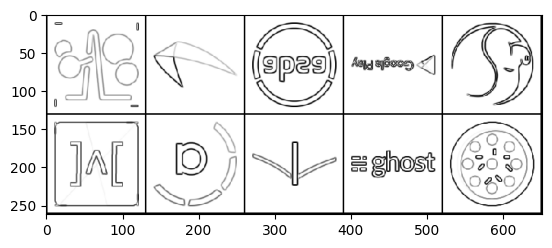

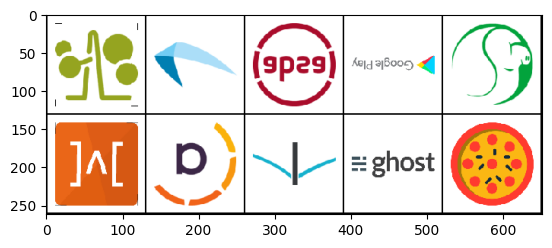

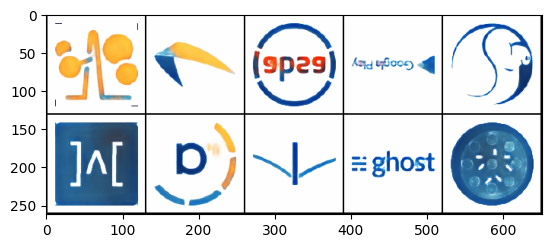

Epoch 0: Step 200: Generator (U-Net) loss: 18.154341678619378, Discriminator loss: 0.42876401118934143


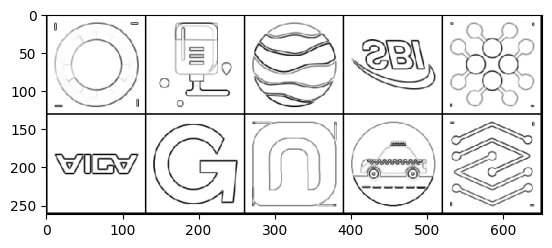

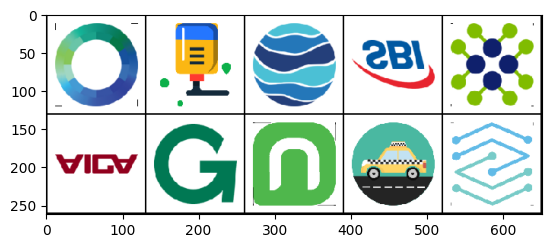

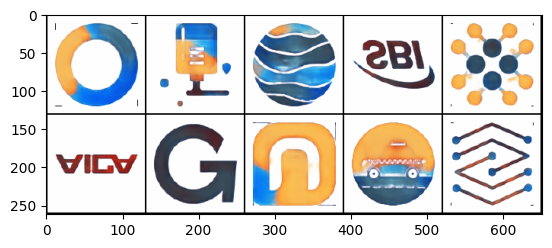

Epoch 0: Step 400: Generator (U-Net) loss: 17.60807493209839, Discriminator loss: 0.5330775656178596


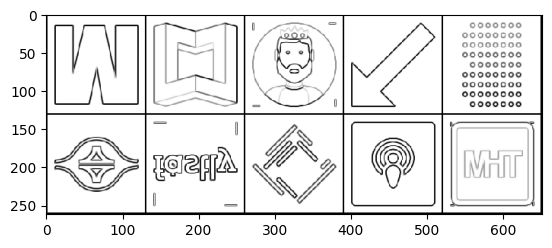

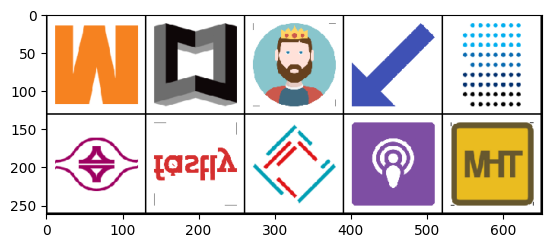

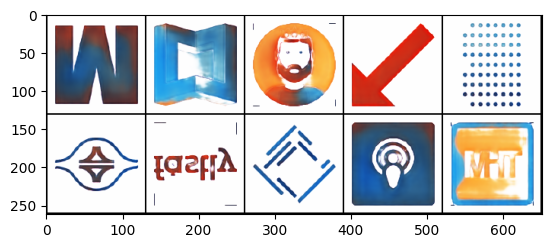

Epoch 0: Step 600: Generator (U-Net) loss: 18.350199980735773, Discriminator loss: 0.37833957139402585


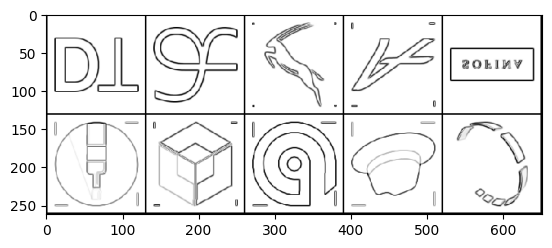

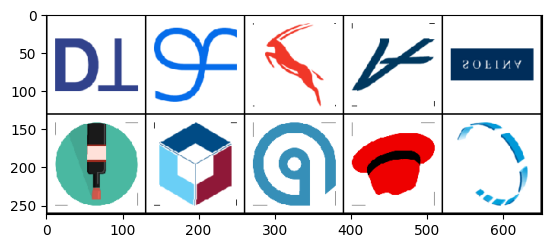

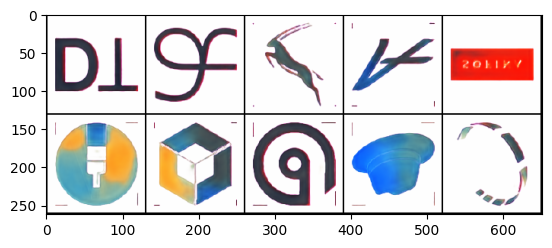

  0%|          | 0/666 [00:00<?, ?it/s]

Epoch 1: Step 800: Generator (U-Net) loss: 19.57526185512543, Discriminator loss: 0.29893727922812113


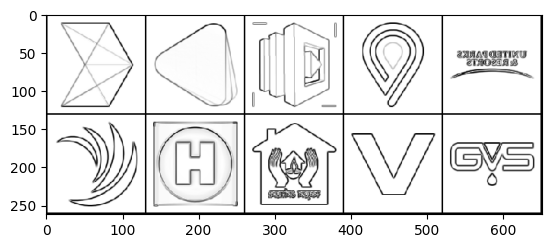

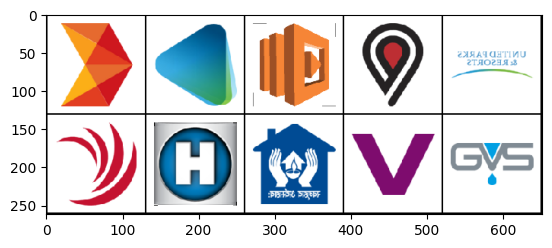

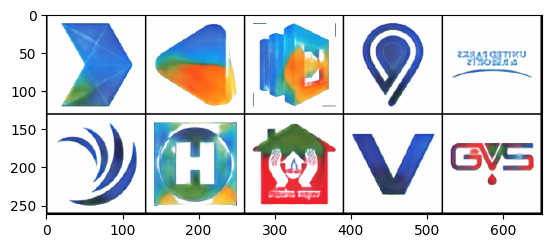

Epoch 1: Step 1000: Generator (U-Net) loss: 18.703886780738834, Discriminator loss: 0.47983415242284533


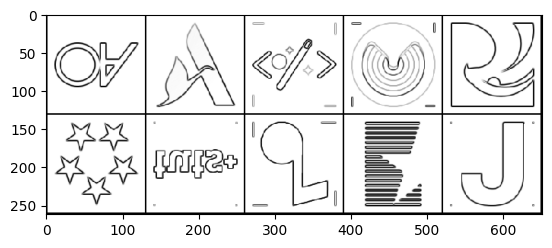

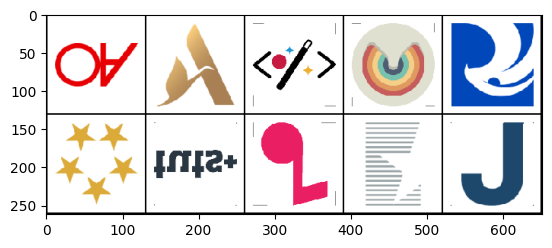

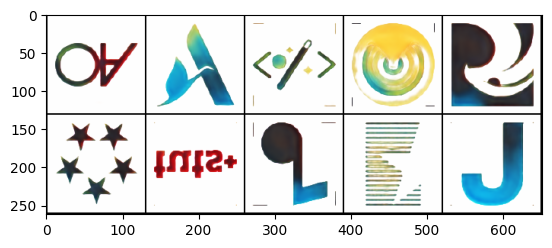

Epoch 1: Step 1200: Generator (U-Net) loss: 18.68022170066833, Discriminator loss: 0.44648275470361143


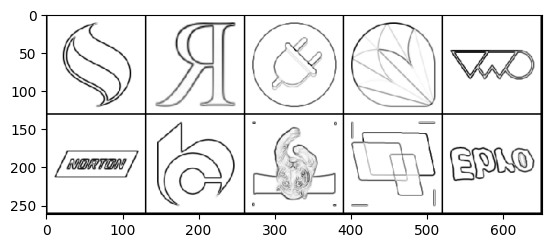

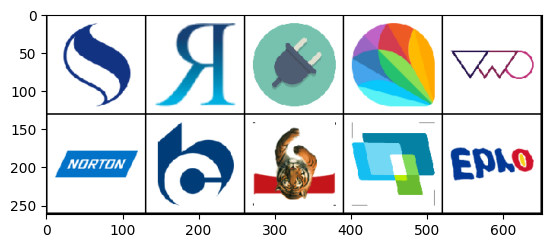

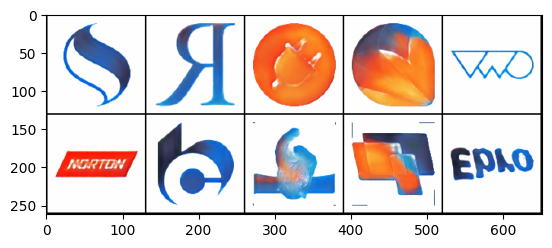

  0%|          | 0/666 [00:00<?, ?it/s]

Epoch 2: Step 1400: Generator (U-Net) loss: 18.20596637248993, Discriminator loss: 0.4484992595762013


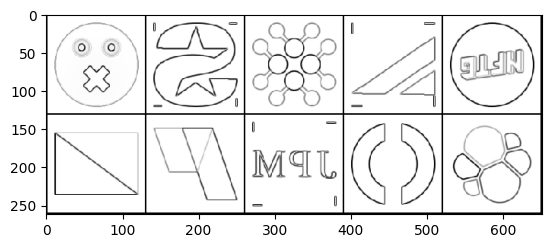

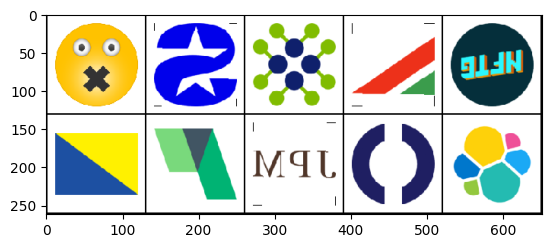

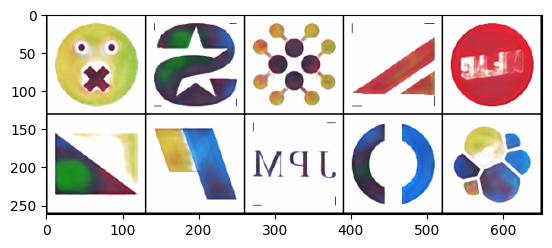

Epoch 2: Step 1600: Generator (U-Net) loss: 17.970589962005615, Discriminator loss: 0.5086335659399629


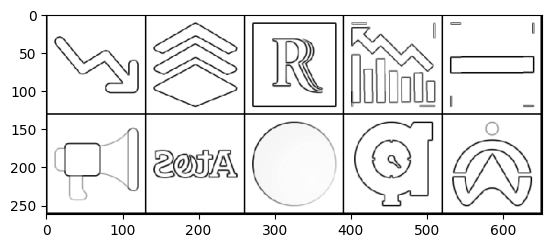

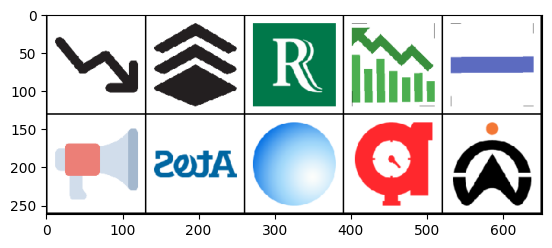

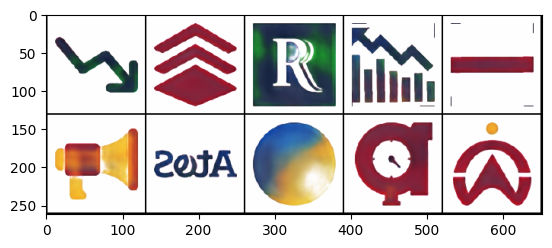

Epoch 2: Step 1800: Generator (U-Net) loss: 18.287389607429507, Discriminator loss: 0.47006074011325877


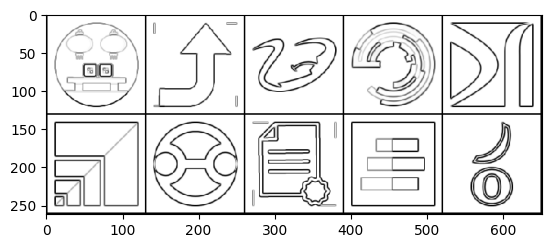

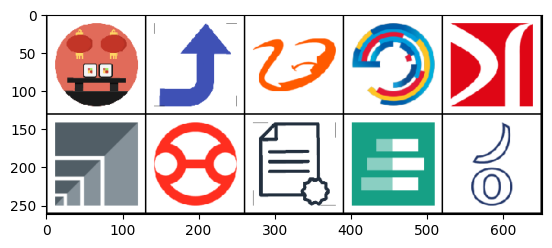

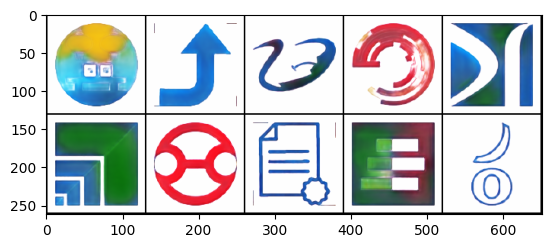

  0%|          | 0/666 [00:00<?, ?it/s]

Epoch 3: Step 2000: Generator (U-Net) loss: 18.02184772014617, Discriminator loss: 0.4496036304160952


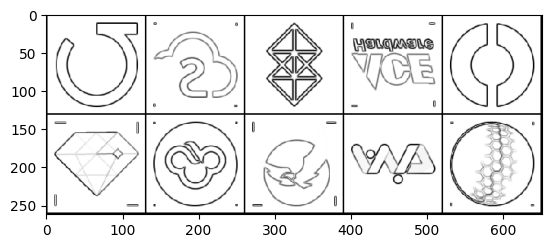

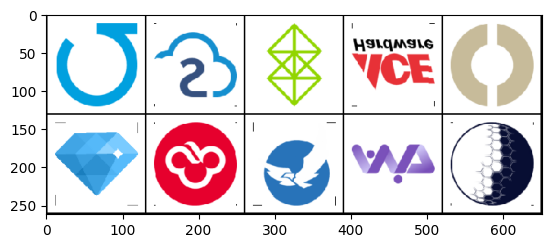

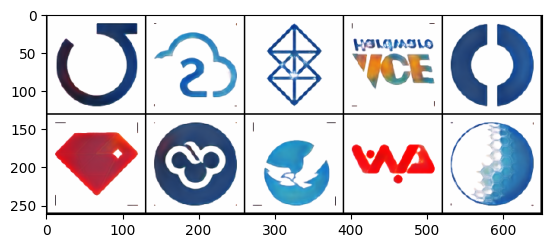

Epoch 3: Step 2200: Generator (U-Net) loss: 17.92772053718567, Discriminator loss: 0.5028905314579606


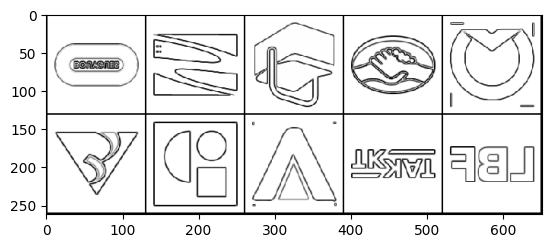

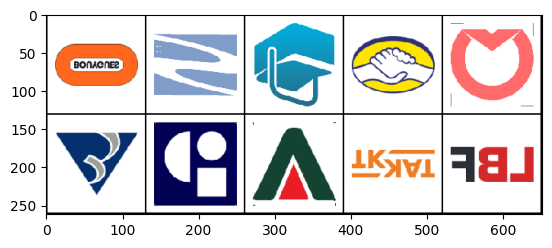

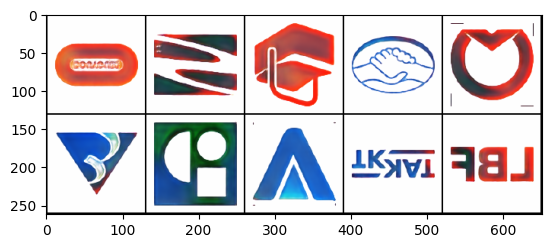

Epoch 3: Step 2400: Generator (U-Net) loss: 18.493255629539476, Discriminator loss: 0.4134761678054927


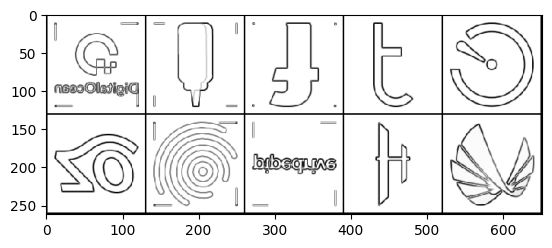

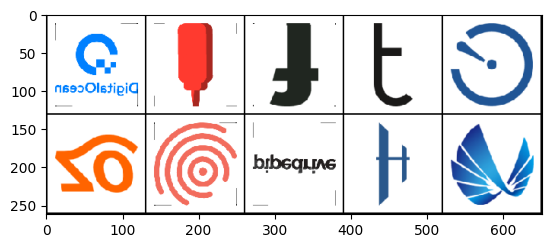

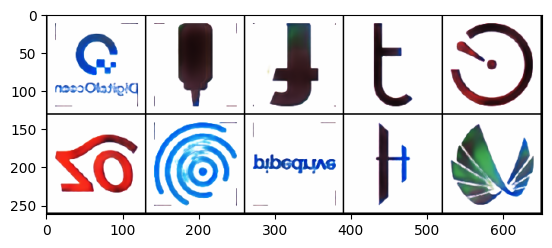

Epoch 3: Step 2600: Generator (U-Net) loss: 18.14743804454803, Discriminator loss: 0.4070088395755738


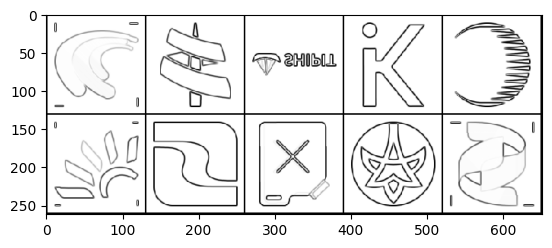

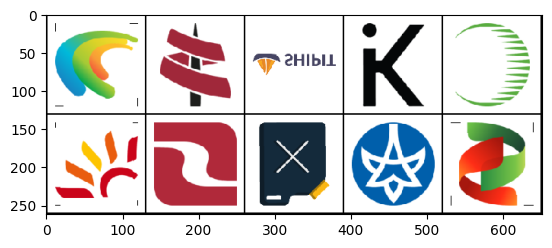

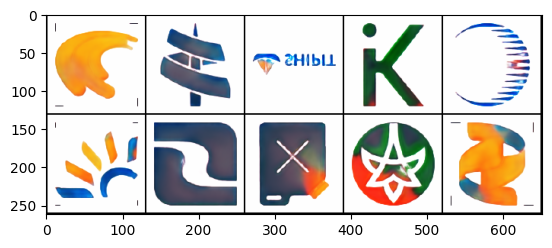

  0%|          | 0/666 [00:00<?, ?it/s]

Epoch 4: Step 2800: Generator (U-Net) loss: 18.954961552619945, Discriminator loss: 0.4029200673662125


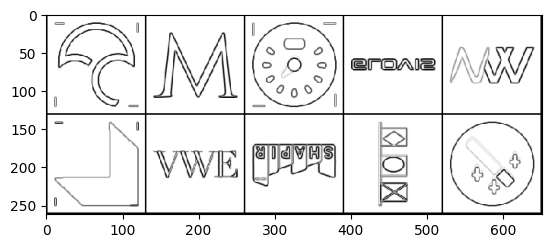

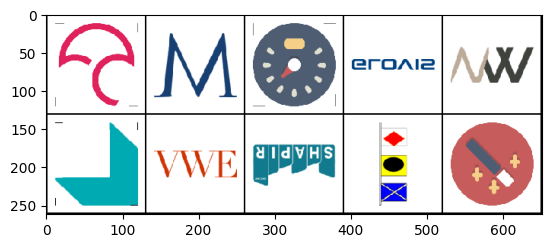

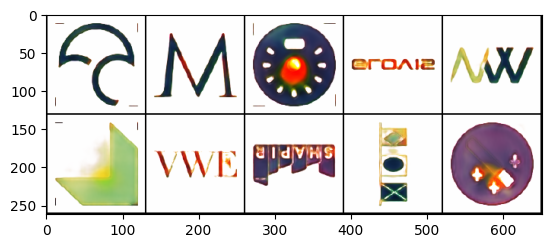

Epoch 4: Step 3000: Generator (U-Net) loss: 17.951811814308176, Discriminator loss: 0.49253559200093155


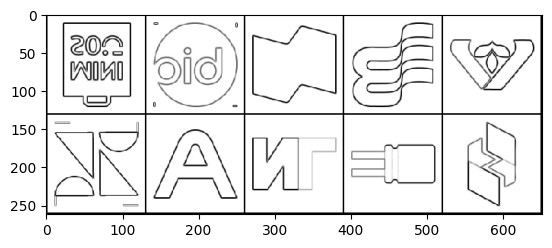

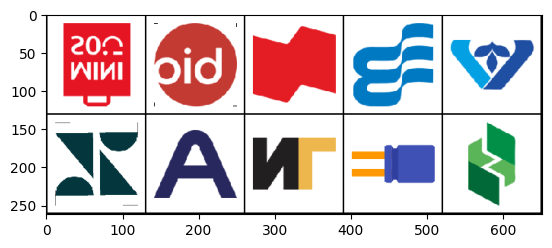

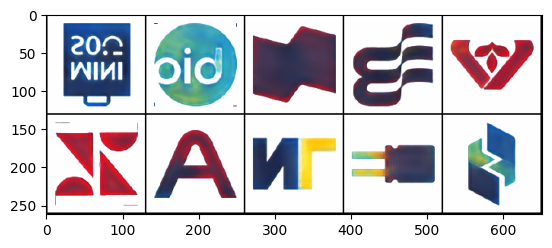

Epoch 4: Step 3200: Generator (U-Net) loss: 17.79753525733948, Discriminator loss: 0.5719490630924701


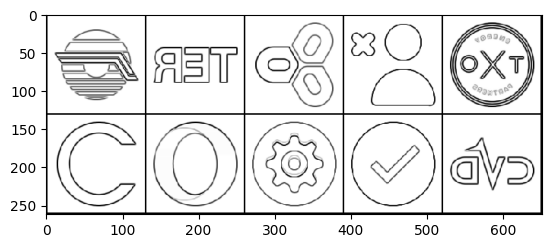

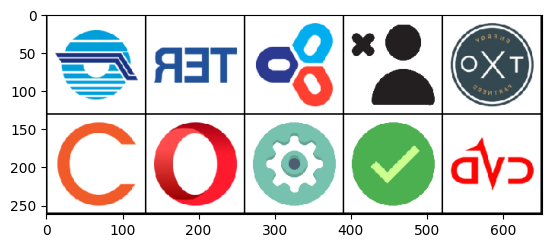

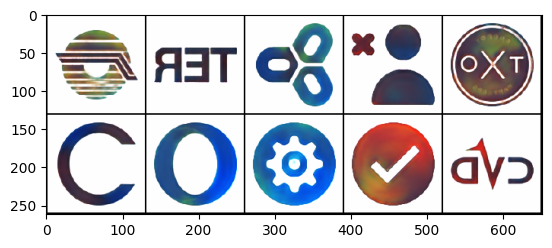

  0%|          | 0/666 [00:00<?, ?it/s]

Epoch 5: Step 3400: Generator (U-Net) loss: 17.727767639160167, Discriminator loss: 0.45897620309144255


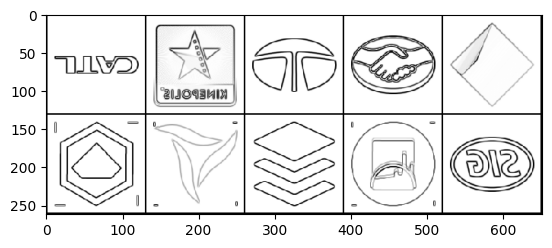

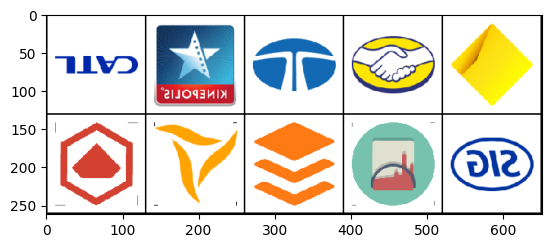

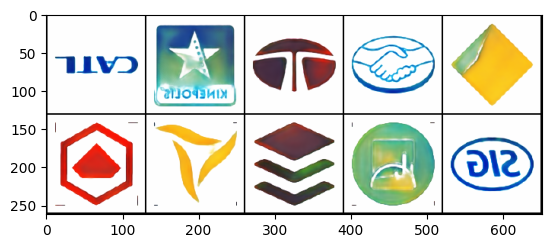

Epoch 5: Step 3600: Generator (U-Net) loss: 18.131004042625424, Discriminator loss: 0.44322384309023616


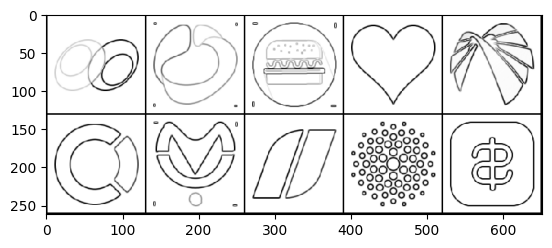

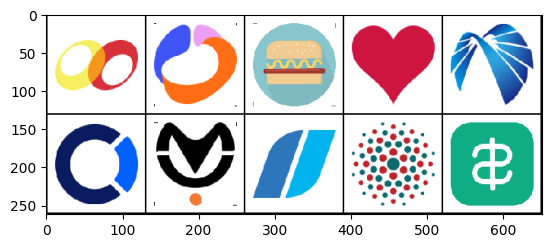

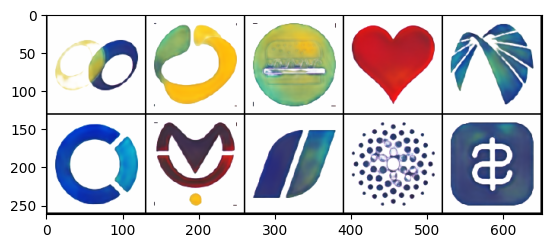

Epoch 5: Step 3800: Generator (U-Net) loss: 18.149822764396678, Discriminator loss: 0.4151150085777045


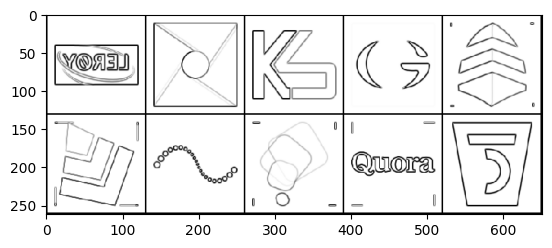

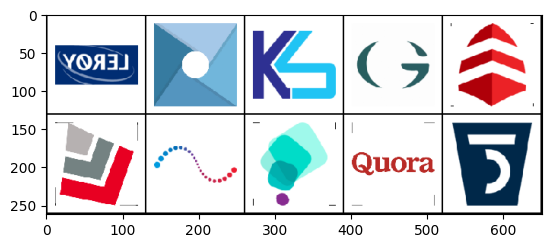

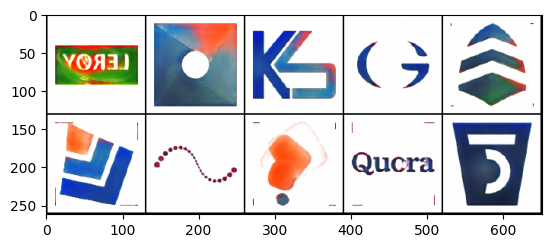

  0%|          | 0/666 [00:00<?, ?it/s]

Epoch 6: Step 4000: Generator (U-Net) loss: 18.803810467720023, Discriminator loss: 0.3951723211444916


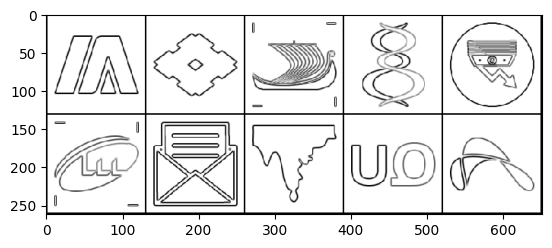

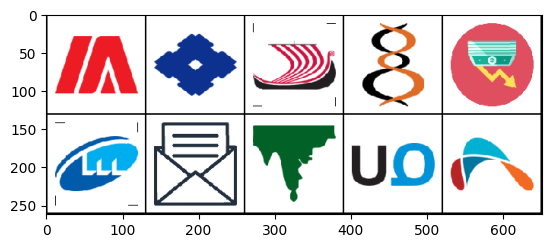

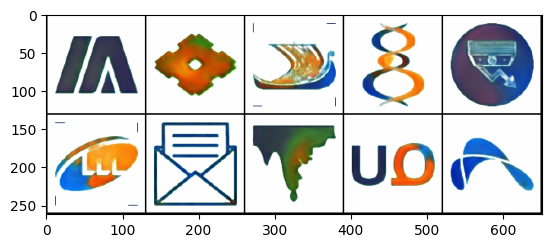

Epoch 6: Step 4200: Generator (U-Net) loss: 18.385363039970393, Discriminator loss: 0.418909618128091


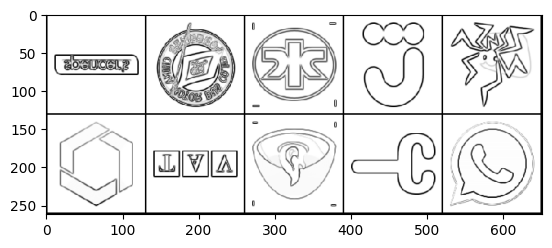

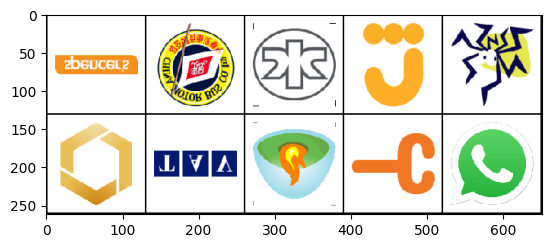

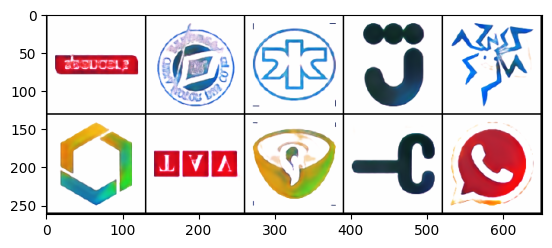

Epoch 6: Step 4400: Generator (U-Net) loss: 18.480176553726196, Discriminator loss: 0.5046816321462394


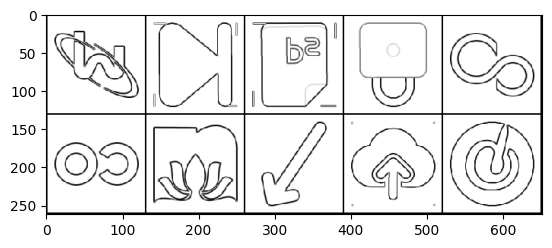

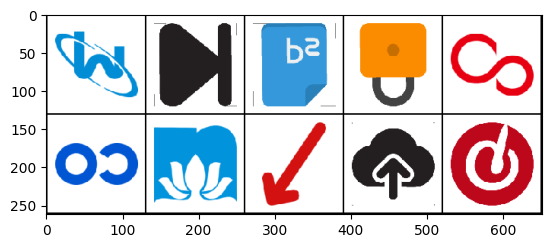

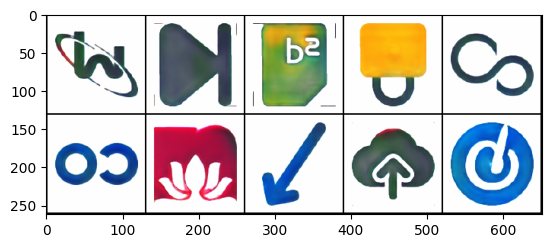

Epoch 6: Step 4600: Generator (U-Net) loss: 18.422773890495296, Discriminator loss: 0.41617676649242624


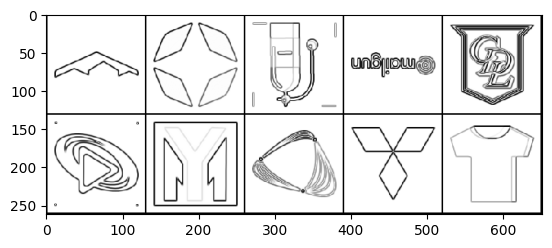

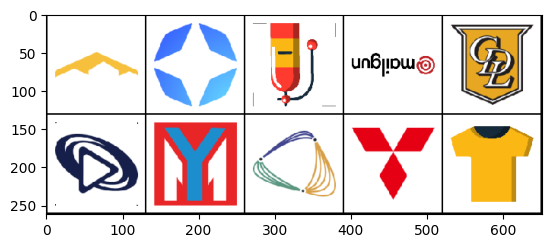

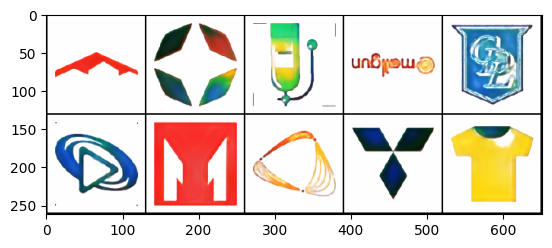

  0%|          | 0/666 [00:00<?, ?it/s]

Epoch 7: Step 4800: Generator (U-Net) loss: 18.108230385780335, Discriminator loss: 0.40262949870899345


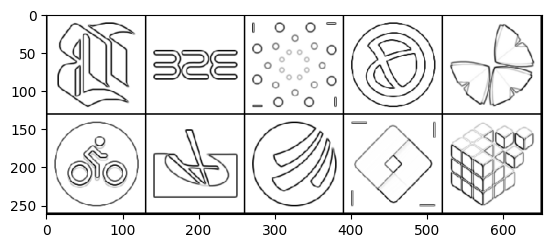

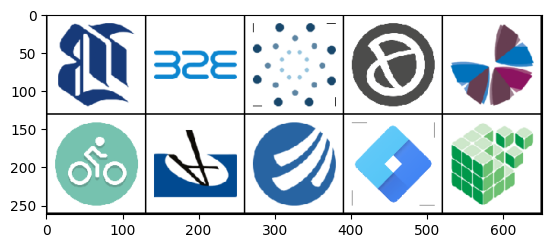

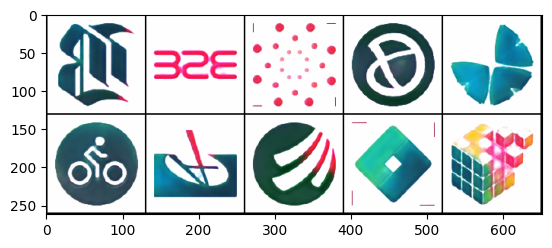

Epoch 7: Step 5000: Generator (U-Net) loss: 19.422267217636108, Discriminator loss: 0.3841364625468852


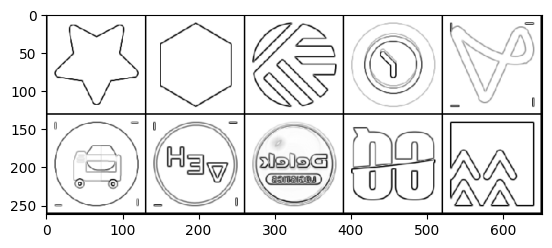

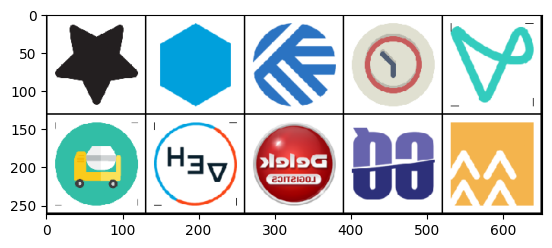

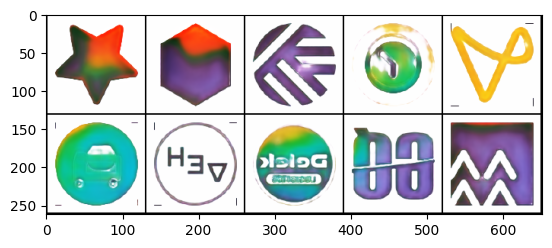

Epoch 7: Step 5200: Generator (U-Net) loss: 17.920335912704477, Discriminator loss: 0.449412574879825


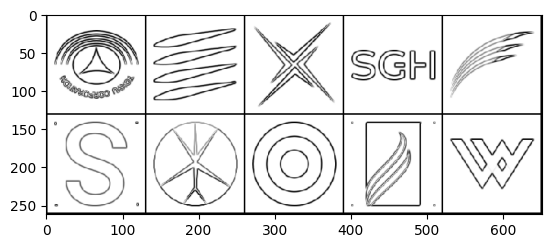

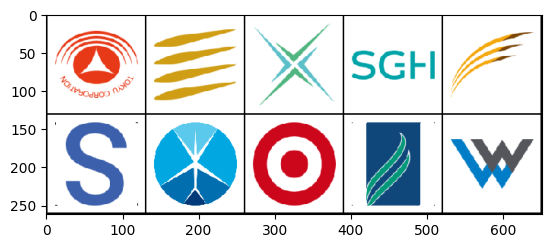

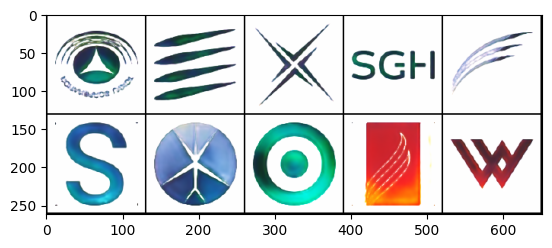

  0%|          | 0/666 [00:00<?, ?it/s]

Epoch 8: Step 5400: Generator (U-Net) loss: 18.439995074272158, Discriminator loss: 0.4705147267319262


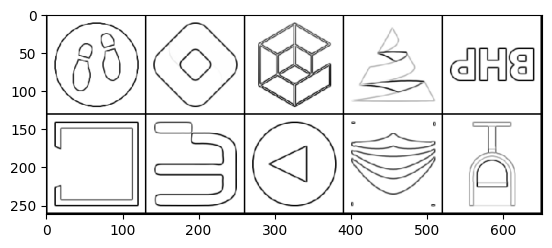

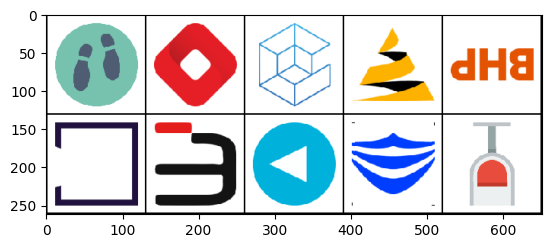

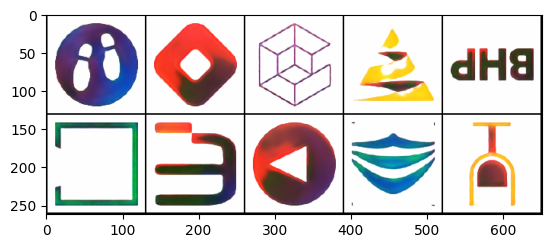

Epoch 8: Step 5600: Generator (U-Net) loss: 18.510509262084963, Discriminator loss: 0.37230385767295965


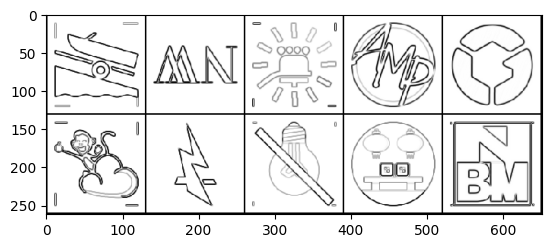

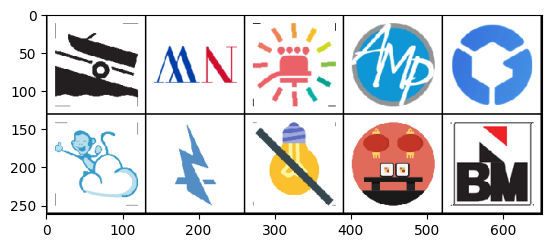

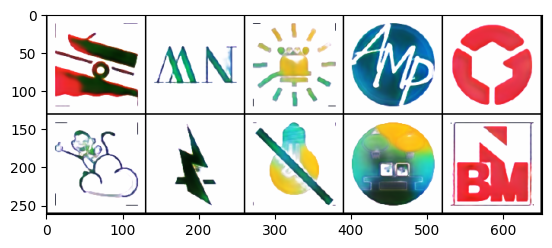

Epoch 8: Step 5800: Generator (U-Net) loss: 18.850314536094672, Discriminator loss: 0.3538716955110429


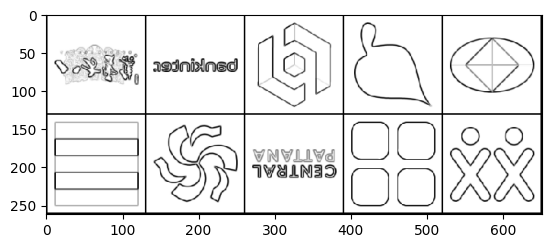

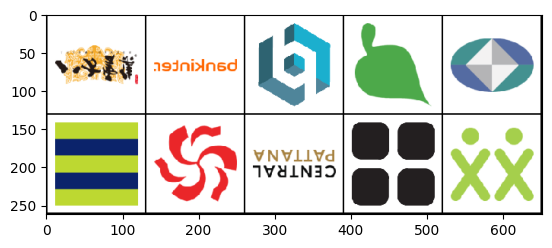

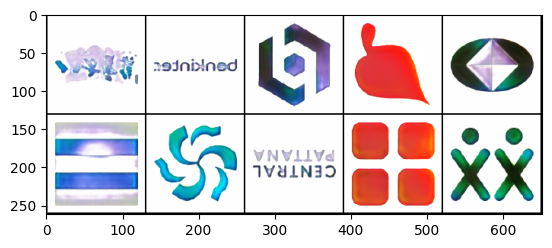

  0%|          | 0/666 [00:00<?, ?it/s]

Epoch 9: Step 6000: Generator (U-Net) loss: 18.80879901885986, Discriminator loss: 0.39025558805093186


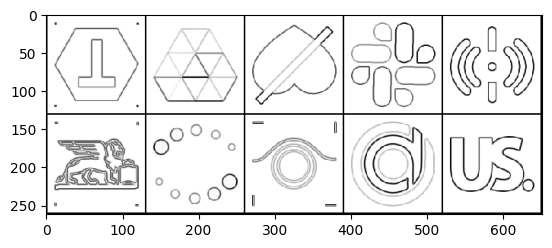

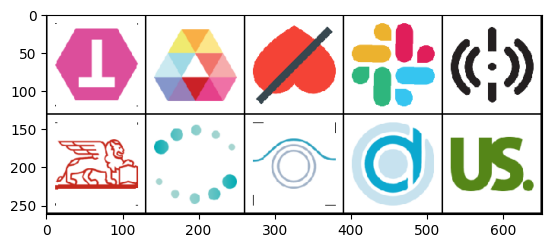

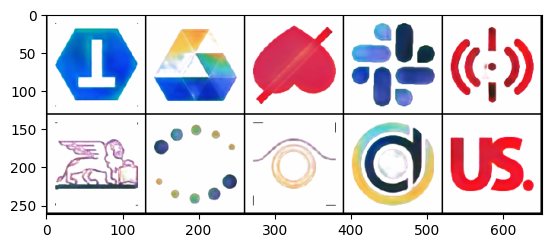

Epoch 9: Step 6200: Generator (U-Net) loss: 18.50479154586792, Discriminator loss: 0.4861473742127417


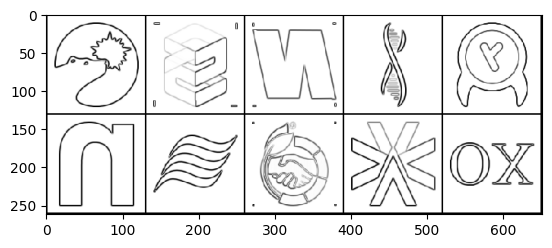

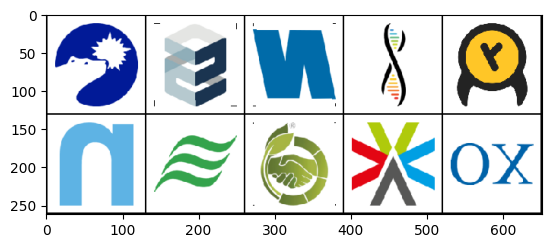

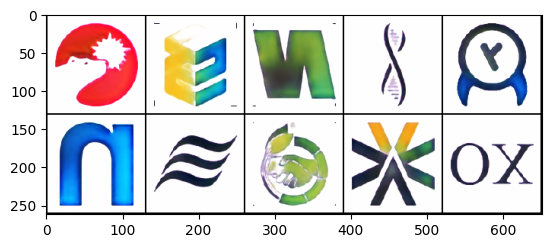

Epoch 9: Step 6400: Generator (U-Net) loss: 18.507386536598197, Discriminator loss: 0.4084948008507488


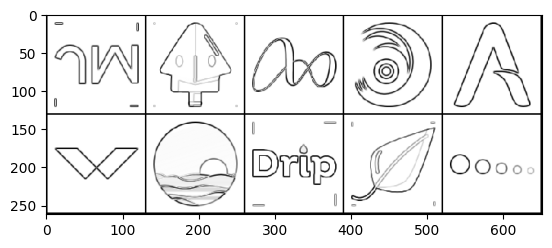

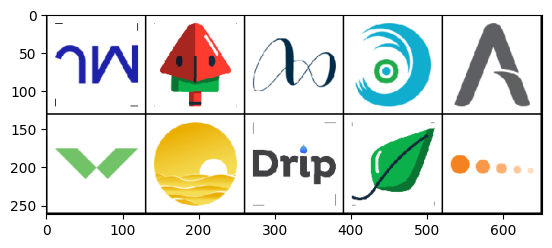

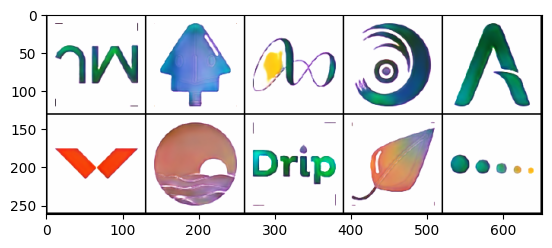

Epoch 9: Step 6600: Generator (U-Net) loss: 19.0487286901474, Discriminator loss: 0.4264442289248108


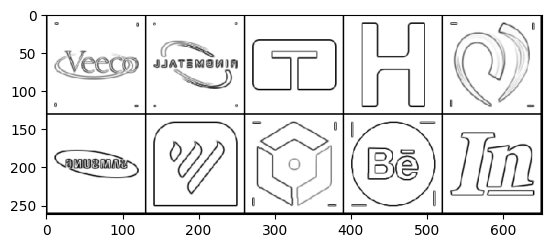

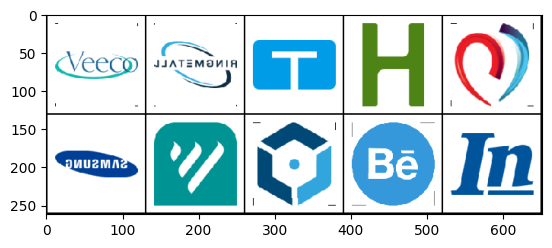

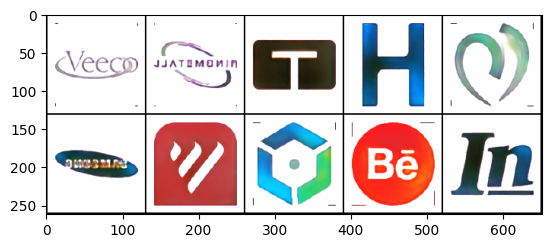

In [25]:
n_epochs = 10
train(dataloader)

In [34]:
torch.cuda.empty_cache()


In [26]:
torch.save({'gen': gen.state_dict(),
            'gen_opt': gen_opt.state_dict(),
            'disc': disc.state_dict(),
            'disc_opt': disc_opt.state_dict()},
f"/kaggle/working/pix2pix_Logos.pth")

In [56]:
img = cv2.imread('/kaggle/input/imagetotest/Screenshot 2024-07-19 at 12.53.39 AM.png')
#img = cv2.resize(img, (128,128))
#img = cv2.normalize(img, None, 0, 1, cv2.NORM_MINMAX)



In [81]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128,128), antialias=None),
    #add_extra,
    #transforms.Resize((128,128), antialias=None),
    #transforms.ToTensor()
    
    
])

In [82]:
from PIL import Image

image_path = '/kaggle/input/imagetotest/Screenshot 2024-07-19 at 12.53.39 AM.png'  # Replace with your image path
image = Image.open(image_path)

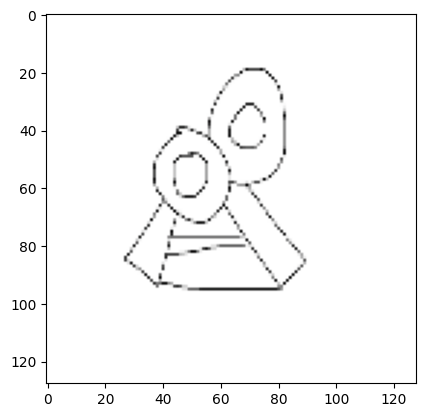

In [90]:
plt.imshow((transform_test(image))[:3,:,:].permute(1,2,0).numpy())

In [97]:
img = transform_test(image)[:3,:,:].reshape(1,3,128,128).to('cuda')
genImage = gen(img)

In [98]:
genImage.shape

torch.Size([1, 3, 128, 128])

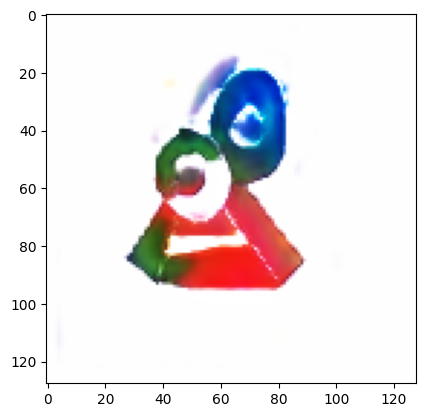

In [101]:
plt.imshow(genImage[0].permute(1,2,0).detach().cpu().numpy())